##  Binary Classification_Perceptron_MLP

#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


## The dataset contains historical data for inventory-active products from the previous 8 weeks of the week we would like to predict, captured as a photo of all inventory at the beginning of the week.

## Attributes
- SKU: Unique material identifier;
- INV: Current inventory level of material;
- TIM: Registered transit time;
- FOR-: Forecast sales for the next 3, 6, and 9 months;
- SAL-: Sales quantity for the prior 1, 3, 5, and 9 months;
- MIN: Minimum recommended amount in stock (MIN);
- OVRP: Parts overdue from source;
- SUP-: Supplier performance in last 1 and 2 semesters;
- OVRA: Amount of stock orders overdue (OVRA);
- RSK-: General risk flags associated to the material;
- BO: Product went on backorder.

Evaluation Metrics
We applied Area Under Receiver Operator Curve (AUROC) for primary evaluation, and Precision-Recall curves for post-analysis.

#### Loading the data

In [53]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

In [3]:
#Check number of rows and columns
data.shape

(10000, 23)

In [4]:
#Display columns
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [5]:
#Display index
data.index

RangeIndex(start=0, stop=10000, step=1)

See the top rows of the data

In [6]:
# Check top 'n' rows
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


In [7]:
#Summary statistics of each column
data.describe()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.000000e+04,10000.000000,9433.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.046242e+06,267.388700,7.561645,26.115800,137.912800,248.780900,355.819500,36.492100,108.298300,209.889800,314.248600,36.063200,1.567400,-6.284197,-5.869804,1.716900
std,6.590184e+05,3937.266534,6.470560,340.288412,1458.350464,2511.049468,3425.324204,288.688666,801.982281,1515.773389,2200.196573,304.328827,27.482543,25.575629,24.859075,44.798882
min,1.111652e+06,-2999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000
25%,1.510146e+06,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630000,0.640000,0.000000
50%,1.898042e+06,10.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,6.000000,0.000000,0.000000,0.820000,0.800000,0.000000
75%,2.811447e+06,55.000000,8.000000,0.000000,12.000000,25.000000,37.000000,5.000000,17.000000,34.000000,49.000000,3.000000,0.000000,0.960000,0.950000,0.000000
max,3.284750e+06,364065.000000,52.000000,20047.000000,98548.000000,169720.000000,214848.000000,10698.000000,35076.000000,67129.000000,89727.000000,16642.000000,1488.000000,1.000000,1.000000,2999.000000


Display data type of each variable

In [8]:
# Check data type of each attribute
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [9]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [10]:
#Display data type of each variable
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [11]:
np.size(np.unique(data.sku, return_counts=True)[0])

10000

In [12]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [13]:
data.isnull().sum()

national_inv           0
lead_time            567
in_transit_qty         0
forecast_3_month       0
forecast_6_month       0
forecast_9_month       0
sales_1_month          0
sales_3_month          0
sales_6_month          0
sales_9_month          0
min_bank               0
potential_issue        0
pieces_past_due        0
perf_6_month_avg       0
perf_12_month_avg      0
local_bo_qty           0
deck_risk              0
oe_constraint          0
ppap_risk              0
stop_auto_buy          0
rev_stop               0
went_on_backorder      0
dtype: int64

Observing the number of records before and after missing value records removal

In [14]:
print (data.shape)

(10000, 22)


In [15]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data = data.dropna(axis=0)

In [16]:
data.isnull().sum()
print(data.shape)

(9433, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and Linear Regression model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [17]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


Creating dummy variables.

    If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [18]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [19]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",
                      drop_first=True)

In [20]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (9433, 22)


#### Target attribute distribution

In [21]:
pd.value_counts(data['went_on_backorder_Yes'])

0    7632
1    1801
Name: went_on_backorder_Yes, dtype: int64

#### Split the data in to train and test

sklearn.model_selection.train_test_split

    Split arrays or matrices into random train and test subsets

In [22]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [23]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    5372
1    1231
dtype: int64
0    2260
1     570
dtype: int64


In [52]:
y.shape

(9433,)

#### Perceptron Model Building

In [24]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=21, activation='sigmoid', kernel_initializer='normal'))

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
perceptron_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 22        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [27]:
perceptron_model.fit(X_train, y_train, epochs=30, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
6603/6603 [==============================] - 2s 367us/step - loss: 1.1747 - acc: 0.7768
Epoch 2/30
6603/6603 [==============================] - 0s 41us/step - loss: 0.5589 - acc: 0.8266: 0s - loss: 0.5139 - acc: 0.
Epoch 3/30
6603/6603 [==============================] - 0s 50us/step - loss: 0.5140 - acc: 0.8330
Epoch 4/30
6603/6603 [==============================] - 0s 39us/step - loss: 0.4490 - acc: 0.8461
Epoch 5/30
6603/6603 [==============================] - 0s 38us/step - loss: 0.4100 - acc: 0.8510
Epoch 6/30
6603/6603 [==============================] - 0s 41us/step - loss: 0.3957 - acc: 0.8516
Epoch 7/30
6603/6603 [==============================] - 0s 43us/step - loss: 0.3969 - acc: 0.8537: 0s - loss: 0.3946 - acc: 0.8
Epoch 8/30
6603/6603 [==============================] - 0s 46us/step - loss: 0.3924 - acc: 0.8542
Epoch 9/30
6603/6603 [==============================] - 0s 52us/step - loss: 0.3855 - acc: 0.8566
Epoch 10/3

#### Predictions

In [28]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [29]:
print("Train data target \n", pd.value_counts(y_train))
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print("\n Confusion matrix \n", confusion_matrix_train)

print("\n Test data target \n", pd.value_counts(y_test))
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print("\n Confusion matrix \n", confusion_matrix_test)

Train data target 
 0    5372
1    1231
dtype: int64

 Confusion matrix 
 [[5203  169]
 [ 651  580]]

 Test data target 
 0    2260
1     570
dtype: int64

 Confusion matrix 
 [[2192   68]
 [ 310  260]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [30]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+
                                                                          confusion_matrix_train[0,1]+
                                                                          confusion_matrix_train[1,0]+
                                                                          confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9685405807892777
Train TPR:  0.471161657189277
Train Accuracy:  0.8758140239285174


In [31]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9699115044247788
Test TPR:  0.45614035087719296
Test Accuracy:  0.8664310954063604


#### MLP Model Building

In [32]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=21, activation='relu', kernel_initializer='normal'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [33]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [34]:
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
mlp_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
6603/6603 [==============================] - 2s 280us/step - loss: 0.5194 - acc: 0.8345
Epoch 2/30
6603/6603 [==============================] - 0s 43us/step - loss: 0.3748 - acc: 0.8440
Epoch 3/30
6603/6603 [==============================] - 0s 43us/step - loss: 0.3418 - acc: 0.8469
Epoch 4/30
6603/6603 [==============================] - 0s 42us/step - loss: 0.3257 - acc: 0.8498
Epoch 5/30
6603/6603 [==============================] - 0s 40us/step - loss: 0.3051 - acc: 0.8622
Epoch 6/30
6603/6603 [==============================] - 0s 44us/step - loss: 0.2962 - acc: 0.8763
Epoch 7/30
6603/6603 [==============================] - 0s 41us/step - loss: 0.3048 - acc: 0.8798
Epoch 8/30
6603/6603 [==============================] - 0s 47us/step - loss: 0.2837 - acc: 0.8890
Epoch 9/30
6603/6603 [==============================] - 0s 50us/step - loss: 0.2857 - acc: 0.8876
Epoch 10/30
6603/6603 [==============================] - 0s 51us/step - loss: 0.2829 - acc: 0.8914
Epoch 11/30
6603/6

In [39]:
mlp_model.get_weights()

[array([[ 2.38857597e-01,  2.99351305e-01, -2.07923546e-01,
          2.03275263e-01, -5.92143983e-02,  1.71573967e-01,
          1.34279490e-01, -3.86291295e-02,  3.37928236e-01,
         -3.29989016e-01,  3.12570751e-01, -2.60761350e-01],
        [-7.80157419e-03,  4.68349364e-03,  3.67997468e-01,
          8.39629173e-02, -3.31520326e-02,  9.04655382e-02,
         -7.22380057e-02, -6.08205982e-02,  1.86506495e-01,
         -9.33333412e-02,  2.72403002e-01,  5.21604538e-01],
        [ 1.09316967e-01,  1.61486223e-01, -1.87740430e-01,
          1.57479763e-01, -1.17294537e-03,  3.91733460e-02,
          1.03300728e-01,  1.09425727e-02,  8.09746683e-02,
         -2.71526892e-02,  1.49105892e-01, -2.01240063e-01],
        [ 1.19734574e-02, -2.79247388e-02, -4.79431115e-02,
         -9.42835435e-02, -1.13925536e-03,  1.14915119e-02,
         -8.54995921e-02, -4.42111157e-02, -8.72286316e-03,
          9.47702397e-03, -5.03995940e-02, -8.73912591e-03],
        [-3.49317044e-02,  3.9732217

In [40]:
X_train.shape

(6603, 21)

In [41]:
mlp_model.count_params()

277

In [42]:
##Number of parameters= (Input*hidden) + hidden + (hiddden*out)+out
no_parameters= (21*12)+ 12+ (12*1) + 1
print(no_parameters)

277


#### Predictions

In [43]:
test_pred=mlp_model.predict_classes(X_test)
train_pred=mlp_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [44]:
print("Train data target \n", pd.value_counts(y_train))
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print("\n Confusion matrix \n", confusion_matrix_train)

print("\n Test data target \n", pd.value_counts(y_test))
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print("\n Confusion matrix \n", confusion_matrix_test)

Train data target 
 0    5372
1    1231
dtype: int64

 Confusion matrix 
 [[5142  230]
 [ 450  781]]

 Test data target 
 0    2260
1     570
dtype: int64

 Confusion matrix 
 [[2160  100]
 [ 209  361]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [45]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+
                                                                          confusion_matrix_train[0,1]+
                                                                          confusion_matrix_train[1,0]+
                                                                          confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9571854058078928
Train TPR:  0.6344435418359058
Train Accuracy:  0.8970165076480388


In [46]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9557522123893806
Test TPR:  0.6333333333333333
Test Accuracy:  0.8908127208480565


#### Plotting ROC curve to modify the threshold if necessary

In [47]:
train_pred_prob=mlp_model.predict(X_train)

In [48]:
print (train_pred_prob)

[[0.0000000e+00]
 [4.9846163e-01]
 [2.2735298e-03]
 ...
 [1.4393301e-07]
 [9.9701043e-03]
 [1.2095915e-19]]


#### Getting ROC curve to adjust the threshold 

In [49]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

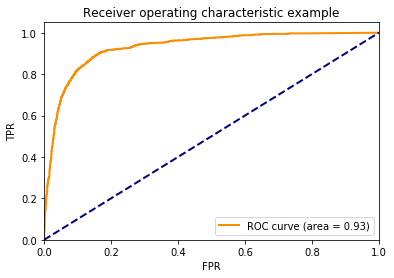

In [50]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()